<div style="float:right">
    <table>
    <tr>
        <td> <img src="../figs/pangeos-small-1.png" alt="PANGEOS" style="width:200px;height:45px;"/> 
        <td> <img src="../figs/kcl_logo.png" alt="King's College London" style="width:54px;height:40px;"/> 
        <td> <img src="../figs/nceo_logo.png" alt="NCEO" style="width:200px;height:40px;"/> 
        <td> <img src="../figs/multiply_logo.png" alt="H2020 Multiply" style="width:40px;height:40px;"/>
    </tr>
    </table>
</div>
&nbsp;





# Inverting Piccolo Doppio spectra using PROSAIL


The idea behind this practical is to allow you to invert reflectance data (plus associated uncertainty) using the PROSAIL model. 


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from pangeos_uq.param_retrieval import BiophysicalRetrievalInSitu
from pangeos_uq.param_retrieval import get_priors
import matplotlib.pyplot as plt
import seaborn as sns

priors = get_priors()

We have a CSV file that contains data on reflectance and uncertainty ($\sigma$ per wavelength:

In [2]:
df = pd.read_csv("../src/pangeos_uq/data/piccolo_refl.csv")
df.head()

,wl,refl,refl_u
0,401.82374,0.026258,0.000949
1,402.61047,0.026386,0.000954
2,403.39714,0.026713,0.000966
3,404.18373,0.026888,0.000972
4,404.97025,0.027230,0.000984


Let's plot the data and uncertainty...

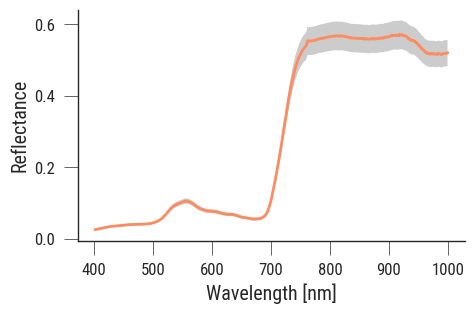

In [3]:
plt.figure(figsize=(5, 3))
plt.plot(df.wl, df.refl, "-")
plt.fill_between(
    df.wl,
    df.refl - 1.95 * df.refl_u,
    df.refl + 1.95 * df.refl_u,
    facecolor="0.8",
)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance");

It would look that the uncertainty is minute everywhere but on the NIR plateau.

1. Can you maybe suggest what parameters may be retrieved with (relativley) higher or lower uncertainty.

The next stage is to produce spectral response functions for the Piccolo system. We're told the FWHM is 1.3 nm, so I will assume that each band has a Gaussian SRF. The standard deviation of Gaussian in terms of FWHM is

$$
\sigma = \frac{FWHM}{2\sqrt{2\log 2}}
$$

Th next block does that:

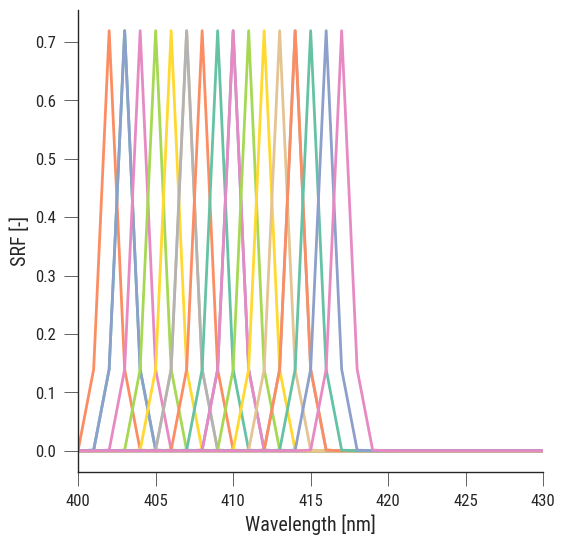

In [4]:
from scipy.ndimage import gaussian_filter1d

# Create the array representing the 400 to 2500 nm range
nm_range = np.linspace(400, 2500, 2101)
wvs = df.wl.to_numpy()
# Create the N x 2101 SRF array
srf = np.zeros((len(wvs), 2101))

# Find the closest index for each wavelength and set that position to 1
closest_indices = np.abs(nm_range[:, None] - wvs).argmin(axis=0)
srf[np.arange(len(wvs)), closest_indices] = 1

# Convert FWHM to standard deviation (sigma)
fwhm = 1.3  # in nm
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Assume nm_range is the array representing the 400 to 2500 nm range
nm_step = np.mean(np.diff(nm_range))  # step size between nm points in nm_range
sigma_pixels = sigma / nm_step  # convert sigma to units of pixels in  nm_range

# Apply Gaussian convolution to each row of the result array
convolved_result = np.array(
    [gaussian_filter1d(row, sigma_pixels) for row in srf]
)
# Normalise so that the integral of the SRF adds up to unity...
srf = convolved_result / convolved_result.sum(axis=1, keepdims=True)


# Plot the first 20 spectral response functions
plt.plot(nm_range, srf[0:20].T)
plt.ylabel("SRF [-]")
plt.xlabel("Wavelength [nm]")
plt.xlim(400, 430);

We next define the "In Situ" object. This needs:
1. The reflectance (d'oh!)
2. The uncertainty (either as a 1D vector of standard deviations or as a full  blown covariance matrix)
3. The spectral response functions array (as above)
4. SZA (in degrees)
5. VZA (in degrees)
6. RAA (in degrees)
7. A prior function (we loaded some up, but you may just want to defne your own)
8. Centre wavelengths

Since I don't really know when the data was collected, I'm just filling in a random SZA angle, but you should be careful with this...

In [5]:
priors = get_priors()

rho = df.refl.values[wvs < 950][::5]
unc = df.refl_u.values[wvs < 950][::5]
wvsx = wvs[wvs < 950][::5]
srfx = srf[wvs < 950][::5]

retrieval = BiophysicalRetrievalInSitu(
    rho,
    np.sqrt(unc),
    srf=srfx,
    sza=30.0,
    vza=0,
    raa=0,
    prior=priors["late"],
    wvs=wvsx,
)

Now, we can just invert. We can use 20000 iterations. It might take a while...

In [6]:
retrieval.run_mcmc(n_samples=10_000)

Sampling:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling: 100%|██████████| 10000/10000 [00:57<00:00, 174.87it/s]

Saved posterior samples to 2024-10-03T22-22-13.349062_posterior_samples.npz


Text(0, 0.5, 'Reflectance [-]')

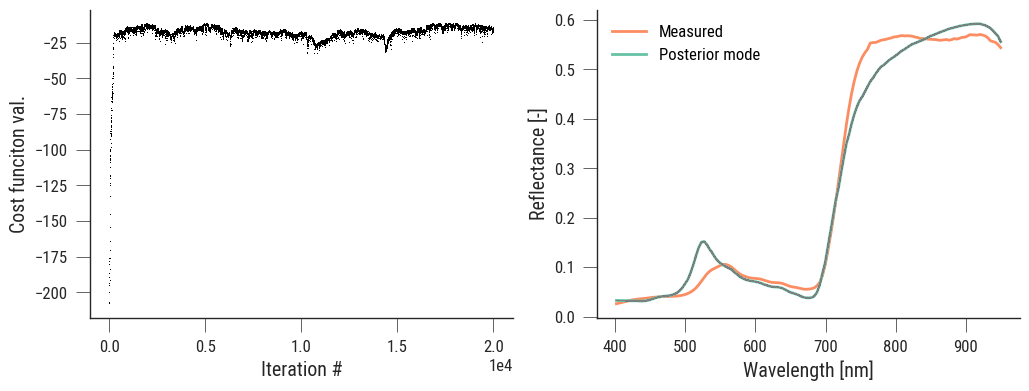

In [7]:
retrieval.plot_posterior(None)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance [-]")

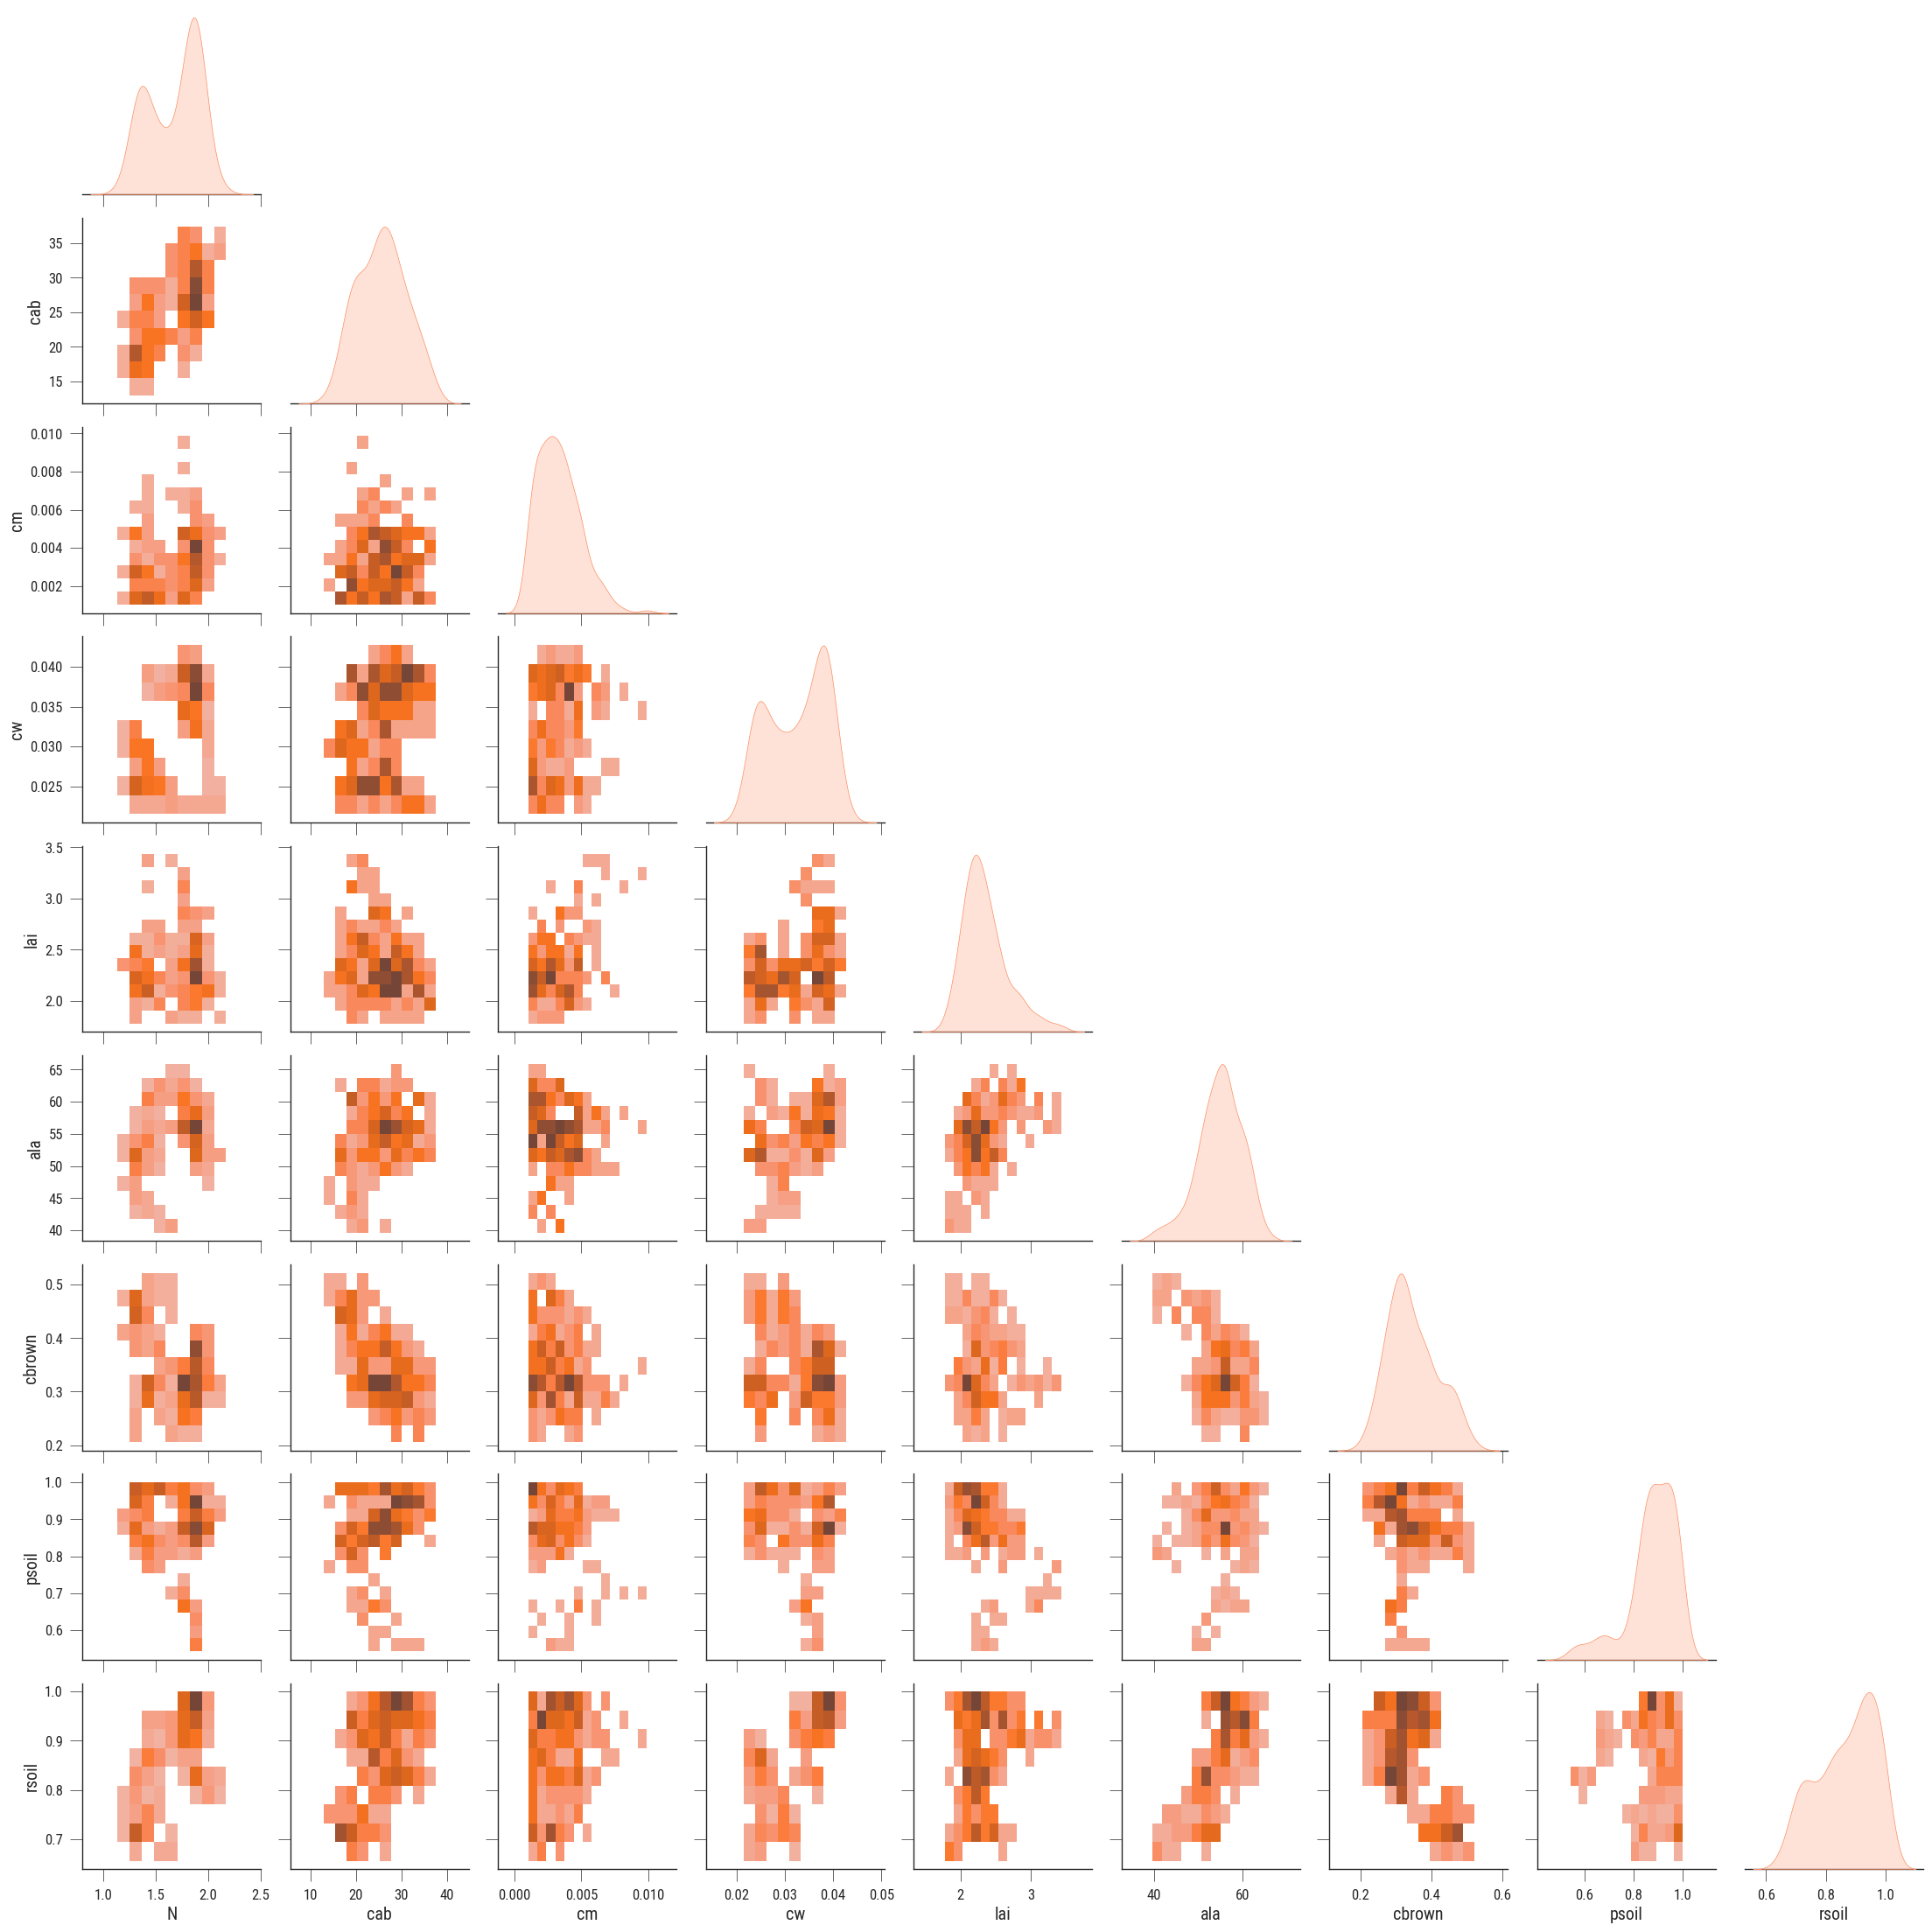

In [8]:
PARAMETERS_NAME = [
    "N",
    "cab",
    "cm",
    "cw",
    "lai",
    "ala",
    "cbrown",
    "psoil",
    "rsoil",
]
posterior_df = pd.DataFrame(
    retrieval.posterior_samples, columns=PARAMETERS_NAME
)

g = sns.pairplot(
    posterior_df.iloc[-2000::10, :], diag_kind="kde", corner=True, kind="hist"
)